# 2016 California Election Exploration

_© Jerod Sun 2020. This is a large project with work in progress._

### Objective: 

Gather insight into voting characteristics and patterns from precinct-by-precinct election results in 2016 combined with census data. Propose questions and targeted campaign strategies based on analysis. Build classification and/or regression models on statistically significant relationships.

### Overview:

To what extend do individual candidates and campaigns persuade voters? On the precinct-level, what kind of voters are more or less likely to vote a split ticket? What about turnout? The results of the last two statewide elections in California provide valuable insight into these questions.

The 2016 and 2018 statewide elections in California featured several unique characteristics. In both years, two Democratic candidates advanced from the blanket primary to the general election for a statewide election. 

- In the 2016 Senate race, California Attorney General Kamala Harris (D) won against Rep. Loretta Sanchez (D). 

- In the 2018 Lieutenant Gubernatorial election, former Ambassador Eleni Kounalakis (D) won against State Sen. Ed Hernandez (D). 

- Also in 2018, Steve Poizner, previously elected Insurance Commissioner as a Republican in 2006, ran as an independent. While Gavin Newsom easily defeated John Cox in the gubernatorial election, Poizner ran a much closer race. 

In 2020, the US will conduct a decennial census. This will provide an up-to-date comparison to the old 2010 data. ESRI (ArcGIS) has provided estimates. Block groups will change; however, the business logic should be idempotent.

`election_exploration_squash_merger.ipynb` contains business logic for joining  precinct Election Data with ArcGIS Census data and the 2017 ACS Survey Data using the relational data obtained from QGIS.


### Voting in California: 

Apart from Presidential races, California has a [top-two primary system](https://ballotpedia.org/Top-two_primary). Therefore, it is possible for two candidates of the same party to compete in the general election.

California also has an early voting period and absentee voting. All citizens can choose to vote by mail when they register to vote (“permanent vote-by-mail voter").

In 2018, several Republican House candidates, such as incumbents Mimi Walters and David Valadao, lead on election night, but absentee ballots postmarked on or before election day ultimately broke the race against their favor. 

### Preliminaries:

Voters are individual decision-makers. Much like financial markets, past performance does not gurantee future results. Quantitative analysis into political voting patterns are useful for analyzing the _result_, not the _decision-making process_. Patterns and macro trends are quantitative - the conclusions and actions to be taken from them are not so obvious.

### Guiding Questions for this Exploration:

- Is there a voting pattern of Hispanics favoring the Hispanic candidate in single-party races? What about other demographic groups?

- What does the visualization of population density vs. candidate percentage look like?

- Counties have evolved quite differently from their original demographics. On the county level, are there any significant trends that differ between counties? Any where linear regression can be applied on each to calculate slope?

- What kind of precincts had the most split-ticket voters? Are there any trends with the delta, normalized for down-ballot drop-off, with any of the census data? Statistically, are these the district types with the most swing voters and candidates and parties should spend the greatest effort in targeting?

- What is the correlation between the candidates and propositions?

In [2]:
# Scientific Computing
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import randint, uniform
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split #, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression

import pickle as p

We will import the results from `election_exploration_squash_merger.ipynb`.

__This is the merged result of Precinct Election Data, ArcGIS Census data and the 2017 ACS Survey Data.__

In [23]:
# Import final dataframe

df = pd.read_csv('2016_sq_result.csv')
print(df.columns[:44])
print(df.columns[44:125])
print(df.columns[125:])

Index(['OBJECTID', 'pres_clinton', 'pres_trump', 'pres_johnson', 'pres_stein',
       'pres_lariva', 'pres_other', 'ussenate_harris', 'ussenate_sanchez',
       'prop51_yes', 'prop51_no', 'prop52_yes', 'prop52_no', 'prop53_yes',
       'prop53_no', 'prop54_yes', 'prop54_no', 'prop55_yes', 'prop55_no',
       'prop56_yes', 'prop56_no', 'prop57_yes', 'prop57_no', 'prop58_yes',
       'prop58_no', 'prop59_yes', 'prop59_no', 'prop60_yes', 'prop60_no',
       'prop61_yes', 'prop61_no', 'prop62_yes', 'prop62_no', 'prop63_yes',
       'prop63_no', 'prop64_yes', 'prop64_no', 'prop65_yes', 'prop65_no',
       'prop66_yes', 'prop66_no', 'prop67_yes', 'prop67_no', 'votedensity'],
      dtype='object')
Index(['STATE_FIPS', 'CNTY_FIPS', 'STCOFIPS', 'TRACT', 'BLKGRP', 'FIPS',
       'POPULATION', 'POP_SQMI', 'POP2010', 'POP10_SQMI', 'WHITE', 'BLACK',
       'AMERI_ES', 'ASIAN', 'HAWN_PI', 'HISPANIC', 'OTHER', 'MULT_RACE',
       'MALES', 'FEMALES', 'AGE_UNDER5', 'AGE_5_9', 'AGE_10_14', 'AGE_15_19',


In [21]:
# Only precincts with significant data

df_sig = df[(df['pres_clinton'] > 10) & (df['pres_trump'] > 10)]

Text(0, 0.5, 'Percent vote for Sanchez')

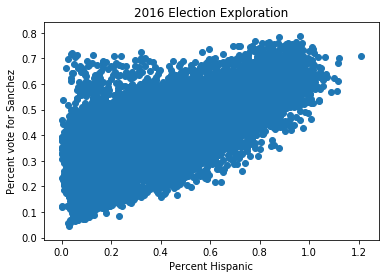

In [22]:
plt.title('2016 Election Exploration')
plt.scatter(df_sig['pct_hispanic'], df_sig['pct_sanchez'])
plt.xlabel('Percent Hispanic')
plt.ylabel('Percent vote for Sanchez')

# Sanchez is from Orange County

Text(0, 0.5, 'Percent vote for Trump')

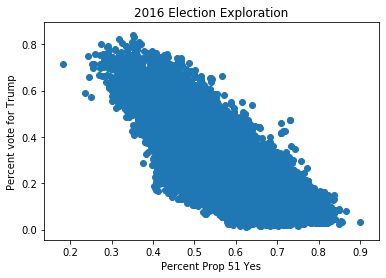

In [25]:
plt.title('2016 Election Exploration')
plt.scatter(df_sig['pct_prop51_yes'], df_sig['pct_trump'])
plt.xlabel('Percent Prop 51 Yes')
plt.ylabel('Percent vote for Trump')

# FYI:
# Total votes: 14,610,509
# President: 14,181,595
# Registered voters: 19,411,771


Text(0, 0.5, 'Percent vote for Trump')

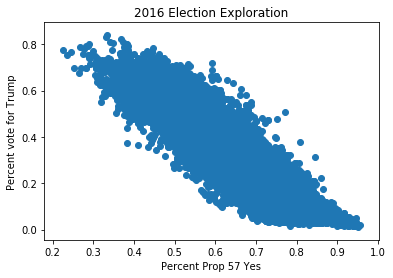

In [27]:
plt.title('2016 Election Exploration')
plt.scatter(df_sig['pct_prop57_yes'], df_sig['pct_trump'])
plt.xlabel('Percent Prop 57 Yes')
plt.ylabel('Percent vote for Trump')

# Total votes: 13,620,436


Text(0, 0.5, 'Percent Trump')

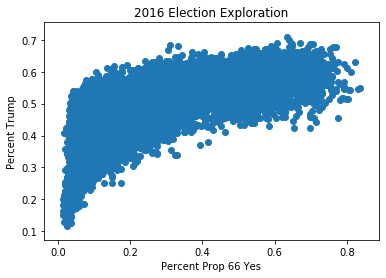

In [29]:
plt.title('2016 Election Exploration')
plt.scatter(df_sig['pct_trump'], df_sig['pct_prop66_yes'])
plt.xlabel('Percent Prop 66 Yes')
plt.ylabel('Percent Trump')

### Background on Prop 65 and Prop 67

List Similarities and Rationale

Prop 65 "Redirects money collected by grocery and certain other retail stores through mandated sale of carryout bags" to a special environmental fund.

Prop 67 "prohibits grocery and other stores from providing customers single–use plastic or paper carryout bags".

Prop 65 failed 46.10% to 53.90%

Prop 67 passed 53.27% to 46.73%

[Full text](https://vig.cdn.sos.ca.gov/2016/general/en/pdf/text-proposed-laws.pdf) of the ballot proposition.
[Alt](https://web.archive.org/web/20161016122612/http://vig.cdn.sos.ca.gov/2016/general/en/pdf/text-proposed-laws.pdf)


[Prop 65](https://en.wikipedia.org/wiki/2016_California_Proposition_65)

[Prop 67](https://en.wikipedia.org/wiki/2016_California_Proposition_67)




### Proposition 65

<img src="./images/CaliforniaProposition65.png" width=300>

### Proposition 67

<img src="./images/CaliforniaProposition67.png" width=300>

Text(0, 0.5, 'Percent Prop 67 Yes')

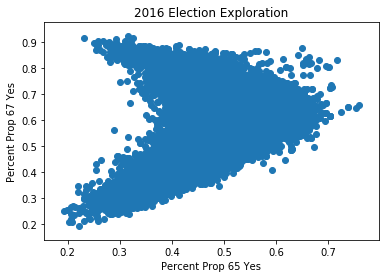

In [55]:
plt.title('2016 Election Exploration')
mask = (df[df['prop65_yes'] > 60])

plt.scatter(mask['pct_prop65_yes'], mask['pct_prop67_yes'])
plt.xlabel('Percent Prop 65 Yes')
plt.ylabel('Percent Prop 67 Yes')

This looks very interesting.

From personal experience, activism in SF contributed to the disparity.

Text(0.5, 1.0, 'All Precincts: Prop 65 vs Prop 67 Vote')

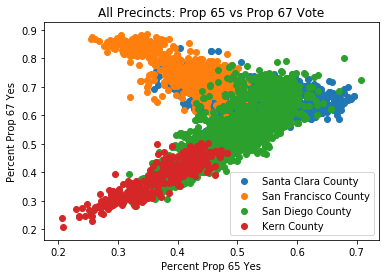

In [54]:
mask = (df[df['prop65_yes'] > 60])

counties = ['Santa Clara County', 'San Francisco County', 'San Diego County', 'Kern County']
for ct in counties:
    plt.scatter(mask[mask['County Name'] == ct]['pct_prop65_yes'], mask[mask['County Name'] == ct]['pct_prop67_yes'])
    
plt.legend(['Santa Clara County','San Francisco County', 'San Diego County', 'Kern County'])
plt.xlabel('Percent Prop 65 Yes')
plt.ylabel('Percent Prop 67 Yes')
plt.title('All Precincts: Prop 65 vs Prop 67 Vote')

Text(0.5, 1.0, 'Majority Non-White Census Blocks Only')

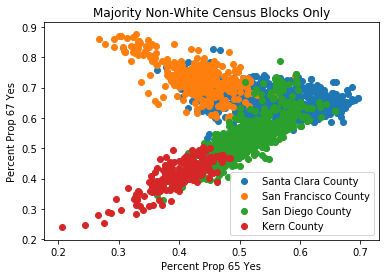

In [53]:
# new mask
mask = (df[df['pct_white'] < .5])
mask = (mask[mask['prop65_yes'] > 60])

counties = ['Santa Clara County', 'San Francisco County', 'San Diego County', 'Kern County']
for ct in counties:
    plt.scatter(mask[mask['County Name'] == ct]['pct_prop65_yes'], mask[mask['County Name'] == ct]['pct_prop67_yes'])
    
plt.legend(['Santa Clara County','San Francisco County', 'San Diego County', 'Kern County'])
plt.xlabel('Percent Prop 65 Yes')
plt.ylabel('Percent Prop 67 Yes')
plt.title('Majority Non-White Census Blocks Only')

Text(0.5, 1.0, 'Majority Non-Hispanic White Census Blocks Only')

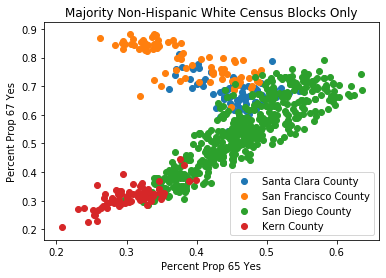

In [52]:
# new mask
mask = (df[df['pct_white'] > .7])
mask = (mask[mask['prop65_yes'] > 20])

counties = ['Santa Clara County', 'San Francisco County', 'San Diego County', 'Kern County']
for ct in counties:
    plt.scatter(mask[mask['County Name'] == ct]['pct_prop65_yes'], mask[mask['County Name'] == ct]['pct_prop67_yes'])
    
plt.legend(['Santa Clara County','San Francisco County', 'San Diego County', 'Kern County'])
plt.xlabel('Percent Prop 65 Yes')
plt.ylabel('Percent Prop 67 Yes')
plt.title('Majority Non-Hispanic White Census Blocks Only')

Text(0.5, 1.0, 'Majority Hispanic Census Blocks Only')

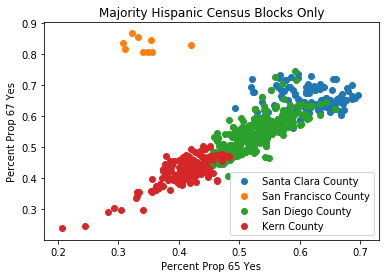

In [51]:
# new mask
mask = (df[df['pct_hispanic'] > .5])
mask = (mask[mask['prop65_yes'] > 20])

counties = ['Santa Clara County', 'San Francisco County', 'San Diego County', 'Kern County']
for ct in counties:
    plt.scatter(mask[mask['County Name'] == ct]['pct_prop65_yes'], mask[mask['County Name'] == ct]['pct_prop67_yes'])
    
plt.legend(['Santa Clara County','San Francisco County', 'San Diego County', 'Kern County'])
plt.xlabel('Percent Prop 65 Yes')
plt.ylabel('Percent Prop 67 Yes')
plt.title('Majority Hispanic Census Blocks Only')

### Build Machine Learning Models